# Creating a map of predicted rainfal over time 

* For a given coordinate (a point in space), we can get the weather predictions from the metno weather API
* Phouc created a (equidistant) grid of points in Malawi (we chose the spacing such that it roughly corresponds to the resolution of the API's data)
* Phouc created shapefiles of all the capture areas of the rivers in Malawi 

The plan therefor is: 
1. Use the API to get the weather predictions over the grid --> use this as our proxy of the entire prediction for Malawi 
2. Use zonal statistics (with zones equal to the capture areas) to produce a map of rainfal predictions - one value per capture area
3. For any given city in Malawi, we then obtain the prediction by using the above map as a lookup: 
    - In other words: Most important to predict the rainfal in city X is how much rain it would capture by overflowing rivers in its neighbourhood.  
    
In this manner, we should not just get the prediction of the rain faling at the city itself, but a measure of how much water will eventually reach the city if all it's surounding rivers would overflow. 

In [5]:
%matplotlib inline
import matplotlib.pylab as plt 
import numpy as np 
import pandas as pd 
from metno_locationforecast import Place, Forecast
import geopandas as gpd 
import rasterio
import rasterstats
import rioxarray
import xarray as xr  
import os 
import zipfile
import cmocean
import seaborn as sns 

import yaml
import datetime

# daily aggregates general

In [124]:
def daily_aggregates(df, aggregate_by):
    # start by resetting index as an ensurance (to make it work in combination with 'groupby' operation)
    df.reset_index(inplace=True, drop=True)
    
    # initialize 
    start_indx_day = 0
    one_day = datetime.timedelta(days=1)
    daily_totals = pd.DataFrame()
    days_predicted_ahead = 0 
    
    # let the algorithm automatically find how many days we have predictions for 
    while start_indx_day < len(df)-1:
        
        # index / timestamps of first and last predictions within a day 
        first_of_day = pd.to_datetime(df.time_of_prediction[start_indx_day])
        end_indx_day  = np.where(pd.to_datetime(df.time_of_prediction)<=first_of_day+one_day)[0][-1]
        last_of_day = pd.to_datetime(df.time_of_prediction[end_indx_day])
        
        # progress number days we could predict for 
        days_predicted_ahead +=1
        
        # slice data to get data belonging to the same day 
        data_of_day = df.iloc[start_indx_day:end_indx_day]
        data_of_day.reset_index(inplace=True, drop=True)
        
        # summarize by adding together the average rainfall over the day
        aggregate_of_day = pd.DataFrame()
        aggregate_of_day['days_ahead'] = [days_predicted_ahead]
        aggregate_of_day['tot_rainfall_mm'] = [data_of_day[aggregate_by].sum()]
        
        
        # combine days into single output 
        daily_totals = pd.concat([daily_totals, aggregate_of_day])
        
        # reset loop: Start from the start of the next day 
        start_indx_day = end_indx_day+1
    return daily_totals 




### daily aggregrates per catchment area 

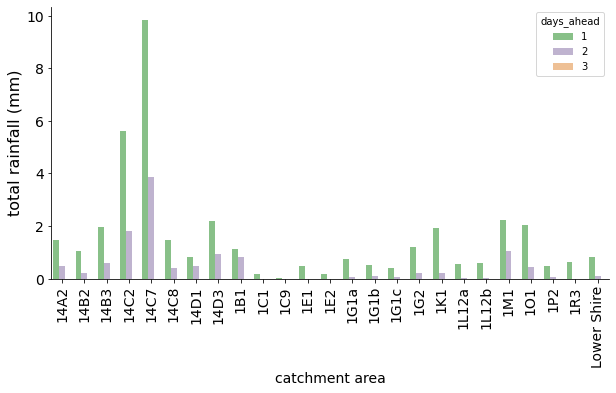

In [125]:
df = pd.read_csv("Malawi_rainfall_zonal.csv")
combine_areas_daily = pd.DataFrame()
for area, group in df.groupby('name'):
    one_area_daily = daily_aggregates(group, aggregate_by='mean')
    one_area_daily['name'] = area
    
    
    combine_areas_daily =  pd.concat([combine_areas_daily, one_area_daily])
    

plt.figure(figsize=(10,5))
sns.barplot(x = 'name', 
            y = 'tot_rainfall_mm', 
            hue = 'days_ahead', 
            data = combine_areas_daily,
            palette = 'Accent',
            # orient = 'horizontal'
       )
plt.xticks(fontsize = 14, rotation = 90);
plt.yticks(fontsize = 14);
plt.xlabel("catchment area", fontsize = 14);
plt.ylabel("total rainfall (mm)", fontsize = 16);
sns.despine();

### daily aggregates of raw predictions (show all pixels)

In [133]:
gdf = gpd.read_file('Malawi_rainfal_long_format.geojson')
gdf = gdf[gdf['predicted_hrs_ahead'] == 1]
df = pd.DataFrame(gdf)

combine_locations_daily = pd.DataFrame()
for (lat,long), group in df.groupby(['latitude','longtitude']):
    one_location_daily = daily_aggregates(group,'rain_in_mm')
    one_location_daily['latitude'] = lat
    one_location_daily['longtitude'] = long
    one_location_daily['geometry'] = group['geometry'].iloc[0]
    combine_locations_daily = pd.concat([combine_locations_daily, one_location_daily])
combine_locations_daily = gpd.GeoDataFrame(combine_locations_daily)


,days_ahead,tot_rainfall_mm,latitude,longtitude,geometry
0,1,1.5,-17.154525,35.148286,POINT (35.14829 -17.15452)
0,2,0.6,-17.154525,35.148286,POINT (35.14829 -17.15452)
0,3,0.0,-17.154525,35.148286,POINT (35.14829 -17.15452)
0,1,1.7,-17.154525,35.248286,POINT (35.24829 -17.15452)
0,2,0.0,-17.154525,35.248286,POINT (35.24829 -17.15452)
...,...,...,...,...,...
0,2,0.0,-14.454525,35.348286,POINT (35.34829 -14.45452)
0,3,0.0,-14.454525,35.348286,POINT (35.34829 -14.45452)
0,1,0.0,-14.454525,35.448286,POINT (35.44829 -14.45452)
0,2,0.0,-14.454525,35.448286,POINT (35.44829 -14.45452)


In [ ]:
'predicted_hrs_ahead' in  gdf.columns

### plot map of raw data (rainfall in mm) with overlay of Catchment area boundaries 

/var/folders/x3/6yf26cqj5v7dn8wy5h5n55hr0000gn/T/ipykernel_1301/516784481.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_da = xr.open_rasterio('Malawi_rainfall.tiff')


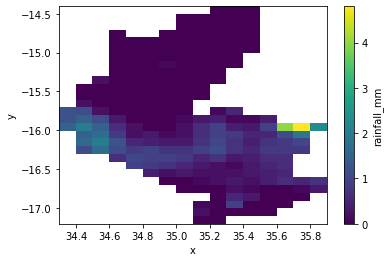

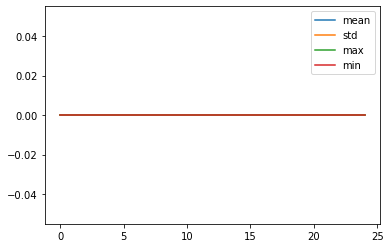

In [98]:
# Open into an xarray.DataArray
geotiff_da = xr.open_rasterio('Malawi_rainfall.tiff')

# Covert our xarray.DataArray into a xarray.Dataset
geotiff_ds = geotiff_da.to_dataset('band')

# Rename the variable to a more useful name
geotiff_ds = geotiff_ds.rename({1: 'rainfall_mm',6:'last'})


geotiff_ds.rainfall_mm.plot()
# geotiff_ds.last.plot()



catchmentAreas = gpd.read_file("./shapefiles/CatchmentsShapefile/")
rainfal_gdf = pd.read_csv('Malawi_rainfall_zonal.csv')
fig = plt.figure()
ax = plt.gca()
# catchmentAreas.boundary.plot(ax = ax, color="coral")
for timestamp, rainfal_prediction in rainfal_gdf.groupby('time_of_prediction'):
    rainfal_prediction.plot(column = 'rain_in_mm', ax = ax)
    break 

<xarray.DataArray 5 (y: 28, x: 16)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ...,  0., nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y        (y) float64 -17.15 -17.05 -16.95 -16.85 ... -14.65 -14.55 -14.45
  * x        (x) float64 34.35 34.45 34.55 34.65 ... 35.55 35.65 35.75 35.85

# Functions 

In [36]:
def read_grid(dirname):
    """
    read in the grid and prep the table by dropping unnecessary columns etc. 
    """
    grid = gpd.read_file(dirname)
    grid.rename({"left":"longtitude", 
                 "top":"latitude"}, axis="columns", inplace = True)
    grid.drop(["right","bottom", "id"], axis = "columns", inplace = True)
    
    grid['geometry'] = gpd.points_from_xy(x = grid['longtitude'], 
                                          y = grid['latitude'])
    return grid 






def API_requests_at_gridpoints(filename_gridpoints = "./shapefiles/grid/", save_to_file = None, 
                               USER_AGENT = "510Global"
                              ):
    """
    use metno weather API to get rainfal predictions at specified set of points
    
    return a GeoDataFrame
    (save this to file)
    """
    grid = read_grid(filename_gridpoints)
    lat = []
    long = []
    geometries = []
    rain_in_mm = []
    time_of_prediction = []
    predicted_hrs_ahead = [] 

    for idx,row in grid.iterrows(): 

        # --- create Place() object --- 
        name = f"point_{idx}"
        point = Place(name,row["latitude"], row["longtitude"])

        # --- create Forecast() object ---- 
        forecast = Forecast(place=point,
                           user_agent=USER_AGENT,
                           forecast_type = "complete",
                           save_location= "./downloads/Malawi/"
                          )

        # --- retrieve latest available forecast from API --- 
        forecast.update()


        # --- add data in long format --- 
        for interval in forecast.data.intervals:
            if "precipitation_amount" in interval.variables.keys():
                prediction = interval.variables['precipitation_amount'].value
                timestamp = interval.start_time
                duration = interval.duration

                rain_in_mm.append(prediction)
                time_of_prediction.append(timestamp)
                predicted_hrs_ahead.append(duration.seconds / 3600.)
                lat.append(row["latitude"])
                long.append(row["longtitude"])
                geometries.append(row["geometry"])


    # --- store long-format data as GeoDataFrame --- 
    rainfall_gdf = gpd.GeoDataFrame()
    rainfall_gdf['rain_in_mm'] = rain_in_mm
    rainfall_gdf['time_of_prediction'] = time_of_prediction
    rainfall_gdf['predicted_hrs_ahead'] = predicted_hrs_ahead
    rainfall_gdf['latitude'] = lat
    rainfall_gdf['longtitude'] = long
    rainfall_gdf['geometry'] = geometries
    
    if save_to_file is not None:
        rainfall_gdf.to_file(save_to_file , driver='GeoJSON')
    return rainfall_gdf

def gdf_to_rasterfile(rainfall_gdf, save_to_file = None):
    """
    convert GeoDataFrame to xarray with dimensions and coordinates equal to latitude, longtitude and the time prediction
    
    
    Produce a geoTIF file with one band per timepoint 
    """
    # --- convert the GeoDataFrame into xarray (to have it as a 3D object with coordinates of lat, long and timepoint) ---- 
    rainfall_array = rainfall_gdf.rename({'longtitude':'x', 'latitude':'y'}, axis ='columns')
    rainfall_array = rainfall_array[rainfall_array['predicted_hrs_ahead'] == 1.]
    rainfall_array.set_index(['time_of_prediction', 'y','x'], inplace = True)
    rainfall_array = rainfall_array['rain_in_mm'].to_xarray()
    
    if save_to_file is not None:
        rainfall_array.rio.to_raster(save_to_file)
    
    return rainfall_array

def zonal_statistics(rasterfile, shapefile, 
                    minval=-np.inf,
                    maxval=+np.inf,
                    aggregate_by=[np.mean, np.max,np.sum], 
                    nameKey = None,
                    pcodeKey = None,
                    polygonKey = 'geometry',
                    band = 1
                    ): 
    
    '''
    Perform zonal statistics on raster data ('.tif') , based on polygons defined in shape file ('.shp')
    
    INPUT:
    - rasterfile: path to TIFF file 
    - shapefile : path to .shp file 
    - aggregate_by: A Python function that returns a single numnber. Will use this to aggregate values per polygon.
    NOTE: Can also provide a list of functions if multiple metrics are disired.
    - minval / maxval : Physical boundaries of quantity encoded in TIFF file. Values outside this range are usually reserved to denote special terrain/areas in image
    - nameKey / pcodeKey : column names in shape file that contain unique identifiers for every polygon 
    - polygonKey : by default geopandas uses the 'geometry' column to store the polygons 
    - band: index of band to read (for data with a single band: just keep default of band = 1)
    
    
    OUTPUT:
    table (DataFrame) with the one-number metric (aggregate) for every zone defined in the provided shape file
    '''
    
    # handle supplying either one or mulitple metrics at once: 
    if type(aggregate_by) != list:
        aggregate_by = [aggregate_by]
    aggregates_of_zones = [[] for i in range(len(aggregate_by))]

        
    
    # ---- open the shape file and access info needed --- 
    shapeData = gpd.read_file(shapefile)
    shapes = list(shapeData[polygonKey])
    if nameKey:
        names = list(shapeData[nameKey])
    if pcodeKey:
        pcodes = list(shapeData[pcodeKey])
        
    # --- open the raster image data --- 
    with rasterio.open(rasterfile, 'r') as src:
        img = src.read(1)
        
        # --- for every polygon: mask raster image and calculate value --- 
        for shape in shapes: 
            out_image, out_transform = rasterio.mask.mask(src, [shape], crop=True)
            
            # --- show the masked image (shows non-zero value within boundaries, zero outside of boundaries shape) ----
            img = out_image[band-1, :, :]

            # --- Only use physical values  ----
            data = img[(img >= minval) & (img <= maxval)]
            
            #--- determine metric: Must be a one-number metric for every polygon ---
            for idx, metric in enumerate(aggregate_by):
                aggregates_of_zones[idx].append( metric(data) )
    
    # --- store output --- 
    zonalStats = pd.DataFrame()
    if nameKey:
        zonalStats['name'] = names
    if pcodeKey:
        zonalStats['pcode'] = pcodes
        
    for idx, metric in enumerate(aggregate_by):
        zonalStats[f'value_{idx+1}'] = aggregates_of_zones[idx]    
    return zonalStats






# pipeline 

In [52]:
def collect_rainfall_data(settings_file):
    
    # --- unpack settings --- 
    with open(settings_file,'r') as f:
        settings = yaml.safe_load(f)
    USER_AGENT = settings['METnoAPI']['user-agent']
    download_dir = settings['METnoAPI']['download_dir']
    file_geotable = settings['METnoAPI']['geotable_file']
    file_points_api_calls = settings['geoCoordinates']['locations_of_interest']
    file_catchment_areas = settings['geoCoordinates']['catchment_areas']
    file_raster_local = settings['on_local']['tif_raw']
    file_raster_cloud = settings['in_cloud']['tif_raw']
    
    # -- Get predictions on grid --- 
    
    print("weather predictions for gridpoints...")
    rainfall_gdf = API_requests_at_gridpoints(save_to_file=file_geotable)
    
    # --- Save as TIF file --- 
    print("save into TIF format....")
    rainfall_array = gdf_to_rasterfile(rainfall_gdf ,save_to_file=file_raster_local)
    
    
    
    # --- perform zonal statistics --- 
    print("zonal stats...")
    # get info in long-format 
    rainfall_per_catchment = pd.DataFrame()
    for band_idx, timepoint in enumerate(rainfall_array.time_of_prediction):
        aggregate = zonal_statistics(rasterfile = file_raster_local,
                                     shapefile = file_catchment_areas, 
                                     minval = 0., # rainfall cannot be negative
                                     aggregate_by = [np.mean, np.std, np.max, np.min],
                                     nameKey = 'name',
                                     polygonKey = 'geometry',
                                     band = band_idx
                                    )

        rename_dict = {"value_1":"mean", 
                       "value_2":"std", 
                       "value_3":"max", 
                       "value_4":"min"}
        aggregate.rename(rename_dict, axis = 'columns', inplace = True)
        aggregate['time_of_prediction'] = pd.to_datetime(timepoint.values)
        rainfall_per_catchment = pd.concat([rainfall_per_catchment, aggregate])
        
    # save to CSV file 
    rainfall_per_catchment.reset_index(drop = True, inplace = True)
    # rainfall_per_catchment.to_csv(file_zonal_stats_local, index = False)
    
    print("done")
    return rainfall_gdf, rainfall_array

weather predictions for gridpoints...


/Users/misha/opt/anaconda3/envs/RK510-RainFallMonitorYr/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


save into TIF format....
zonal stats...
done


/var/folders/x3/6yf26cqj5v7dn8wy5h5n55hr0000gn/T/ipykernel_4191/2221927745.py:5: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_da = xr.open_rasterio('Malawi_rainfall.tiff')


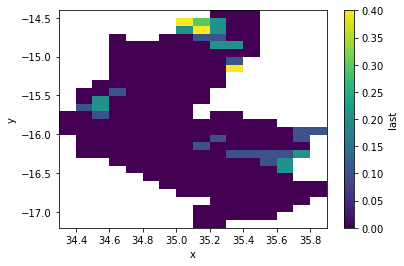

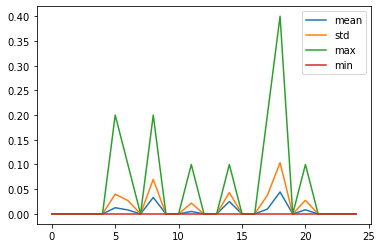

In [76]:
rainfall_gdf, rainfall_array = collect_rainfall_data('local_settings.yml')




/var/folders/x3/6yf26cqj5v7dn8wy5h5n55hr0000gn/T/ipykernel_4191/4284592449.py:10: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  geotiff_da = xr.open_rasterio('Malawi_rainfall.tiff')


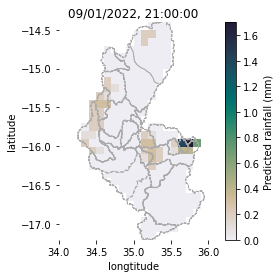

In [230]:
import cmocean

def timestamp_str(timestamp, fmt = "%m/%d/%Y, %H:%M:%S"):
    timestring = pd.to_datetime(timestamp)
    return timestring.strftime(format=fmt)



# Open into an xarray.DataArray
geotiff_da = xr.open_rasterio('Malawi_rainfall.tiff')

# Covert our xarray.DataArray into a xarray.Dataset
# geotiff_da['band'] = rainfall_array.time_of_prediction.values
geotiff_ds = geotiff_da.to_dataset('band')


# Rename the variable to a more useful name
geotiff_ds = geotiff_ds.rename(
    {i:timestamp_str(rainfall_array.time_of_prediction.values[i]) for i in range(1,64)}
)



catchmentAreas = gpd.read_file("./shapefiles/CatchmentsShapefile/")
rainfal_gdf = pd.read_csv('Malawi_rainfall_zonal.csv')
fig = plt.figure()
ax = plt.gca()
catchmentAreas.boundary.plot(ax = ax, color="darkgrey", linewidth = 1., linestyle='dashed')
t = timestamp_str(rainfall_array.time_of_prediction.values[55])
img = geotiff_ds[t].plot(ax=ax, cmap=cmocean.cm.rain, cbar_kwargs={'label':'Predicted rainfall (mm)'})
plt.title(t)
plt.xlabel('longtitude')
plt.ylabel('latitude')
plt.xlim([34, 36])
sns.despine()

sns.despine(bottom=True, left=True)


In [231]:
f"{t.replace('/','_').replace('')}"

'09/01/2022, 21:00:00'

In [235]:
import datetime 
timestamp = pd.to_datetime(rainfall_array.time_of_prediction.values[5])
timestamp.strftime("%Y%m%d_%H_%M_%S")

'20220830_19_00_00'

In [237]:
for f in os.listdir('dummy/'):
    print(os.path.abspath(f))

/Users/misha/Documents/Misha/RedCross510/rainfall-monitor-malawi-metnoAPI/third.txt
/Users/misha/Documents/Misha/RedCross510/rainfall-monitor-malawi-metnoAPI/first.txt
/Users/misha/Documents/Misha/RedCross510/rainfall-monitor-malawi-metnoAPI/.ipynb_checkpoints
/Users/misha/Documents/Misha/RedCross510/rainfall-monitor-malawi-metnoAPI/second.txt


In [242]:
for x in rainfall_array.to_dataset('time_of_prediction'):
    print(x)

2022-08-30 14:00:00
2022-08-30 15:00:00
2022-08-30 16:00:00
2022-08-30 17:00:00
2022-08-30 18:00:00
2022-08-30 19:00:00
2022-08-30 20:00:00
2022-08-30 21:00:00
2022-08-30 22:00:00
2022-08-30 23:00:00
2022-08-31 00:00:00
2022-08-31 01:00:00
2022-08-31 02:00:00
2022-08-31 03:00:00
2022-08-31 04:00:00
2022-08-31 05:00:00
2022-08-31 06:00:00
2022-08-31 07:00:00
2022-08-31 08:00:00
2022-08-31 09:00:00
2022-08-31 10:00:00
2022-08-31 11:00:00
2022-08-31 12:00:00
2022-08-31 13:00:00
2022-08-31 14:00:00
2022-08-31 15:00:00
2022-08-31 16:00:00
2022-08-31 17:00:00
2022-08-31 18:00:00
2022-08-31 19:00:00
2022-08-31 20:00:00
2022-08-31 21:00:00
2022-08-31 22:00:00
2022-08-31 23:00:00
2022-09-01 00:00:00
2022-09-01 01:00:00
2022-09-01 02:00:00
2022-09-01 03:00:00
2022-09-01 04:00:00
2022-09-01 05:00:00
2022-09-01 06:00:00
2022-09-01 07:00:00
2022-09-01 08:00:00
2022-09-01 09:00:00
2022-09-01 10:00:00
2022-09-01 11:00:00
2022-09-01 12:00:00
2022-09-01 13:00:00
2022-09-01 14:00:00
2022-09-01 15:00:00


In [75]:
rainfall_array.time_of_prediction.values

load_tif = xr.open_dataarray('Malawi_rainfall.tiff')
load_tif

<xarray.DataArray 'band' (band: 64)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 ... 56 57 58 59 60 61 62 63 64
    spatial_ref  int64 ...

# Automatically unzip files 

In [160]:
def unzip_shapefiles(dirname = './shapefiles/'):
    """
    Extract contents of the ".zip"-files to get all the information to load shapefiles
    ----
    function will only unzip if needed 
    """
    zipfiles = [os.path.join(dirname, file) for file in os.listdir(dirname) if file.endswith('.zip')]    
    for zipped in zipfiles: 
        extracted = os.path.splitext(zipped)[0]
        if not os.path.exists(extracted):
            with zipfile.ZipFile(zipped, 'r') as archive:
                archive.extractall(extracted)
        
        



unzip_shapefiles()

In [150]:
path = os.path.join('./shapefiles/',item)
path

'./shapefiles/CatchmentsShapefile_dissolved.zip'

In [154]:
os.path.splitext(item)[0]

'CatchmentsShapefile_dissolved'

# only need API calls for points within a catchment area 

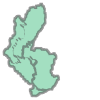

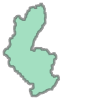

In [172]:
# --- potential way to make this more general (although didn't dissolve all internal boundaries) --- 
catchmentAreas['dummy'] = 42
display(catchmentAreas.dissolve('dummy', ).reset_index()['geometry'][0])

# --- will use this version Phouc prepared in QGIS --- 
gdf = gpd.read_file('./shapefiles/CatchmentsShapefile_dissolved/')
display(gdf['geometry'][0])





In [140]:
completeGrid = gpd.read_file("./shapefiles/grid/")
ROI = gpd.read_file("./shapefiles/CatchmentsShapefile_dissolved/")

completeGrid['is_within_roi'] = completeGrid['geometry'].within(other=ROI['geometry'][0])
requestPoints = completeGrid[completeGrid.is_within_roi].copy()

requestPoints.reset_index(drop = True, inplace = True)
requestPoints.drop(columns = 'is_within_roi', inplace = True)
requestPoints.to_file('./shapefiles/Malawi_API_calls_catchments_dissolved.geojson', driver='GeoJSON')





/Users/misha/opt/anaconda3/envs/RK510-RainFallMonitorYr/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


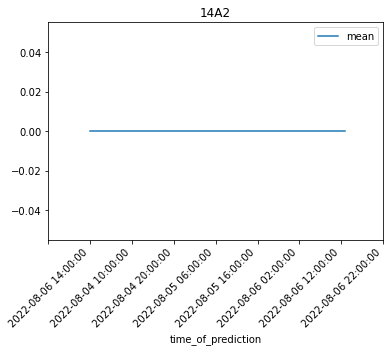

In [75]:
df = pd.read_csv(settings['zonal_stats_catchment'])
for area, group in df.groupby('name'):
    group.plot(x='time_of_prediction', y = 'mean')
    plt.xticks(plt.gca().get_xticks(),rotation = 45)
    plt.title(area)
    break 


In [37]:
# --- unpack settings --- 
USER_AGENT = settings['user-agent']
file_geotable  = settings['geotable_file']
file_raster = settings['raster_file']
file_catchment_areas = settings['catchment_areas']
file_zonal_stats = settings['zonal_stats_catchment']

# get info in long-format 
rainfall_per_catchment = pd.DataFrame()
for band_idx, timepoint in enumerate(rainfall_array.time_of_prediction):
    print(band_idx)
    # print(timepoint.coords['time_of_prediction'])
    break

0


In [50]:
for x in rainfall_array.time_of_prediction:
    break


Timestamp('2022-08-04 09:00:00')

In [76]:
gdf = gpd.read_file(file_geotable)

In [84]:
catchmentAreas = gpd.read_file(settings['catchment_areas'])

gdf['geometry'].within(catchmentAreas['geometry'][0])

880

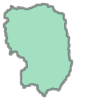

## API requests for gridpoints: Sample Malawi as a set of points, store the data in long format (GeoDataFrame)

In [75]:




# -- Get predictions on grid --- 









# --- perform zonal statistics --- 



/Users/misha/opt/anaconda3/envs/RK510-RainFallMonitorYr/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [83]:
aggregates = zonal_statistics(rasterfile='./temp/Malawi_rainfall.tif',
                 shapefile='./shapefiles/CatchmentsShapefile/',
                 minval=0.,
                 nameKey='name'
                )
rasterfile='./temp/Malawi_rainfall.tif'
with rasterio.open(rasterfile, 'r') as src:
    array = src.read(60)
    print(array.shape)

(29, 18)


In [78]:
rainfall_array.rio.to_raster('./temp/Malawi_rainfall.tif')

RasterioIOError: Dataset is closed: ./temp/Malawi_rainfall.tif

## quick check if we indeed sampled Malawi by overlaying with boundaries of catchment areas. 

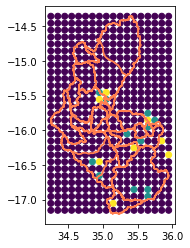

In [63]:
from time import sleep
catchmentAreas = gpd.read_file("./shapefiles/CatchmentsShapefile/")

fig = plt.figure()
ax = plt.gca()
catchmentAreas.boundary.plot(ax = ax, color="coral")
for timestamp, rainfal_prediction in rainfal_gdf.groupby('time_of_prediction'):
    rainfal_prediction.plot(column = 'rain_in_mm', ax = ax)
    break 

While it in principle seems to work, we are clearly also getting weather reports in Mozambique, and Zambia (neighbouring countries)

## Zonal statistics: Get one value per catchment area per timestamp 

In [47]:


rainfal_prediction[["rain_in_mm", "geometry"]].to_file("temp/Malawi_one_timepoint.shp")
catchmentAreas = gpd.read_file("./shapefiles/CatchmentsShapefile/")


rasterstats.gen_zonal_stats()

rasterstats.zonal_stats("./shapefiles/CatchmentsShapefile/", "./temp/Malawi_one_timepoint.shp", stats = "mean")

/Users/misha/opt/anaconda3/envs/RK510-RainFallMonitorYr/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


RasterioIOError: './temp/Malawi_one_timepoint.shp' not recognized as a supported file format.

In [58]:
with rasterio.open("/temp/Malawi.tif", "w", height = 29, width= 18, count=0 ) as tiffFile:
    tiffFile.write(rainfal_prediction[["rain_in_mm", "geometry"]])
    

TypeError: A valid dtype is required.

In [52]:
rainfal_prediction.

,minx,miny,maxx,maxy
0,34.248286,-14.354525,34.248286,-14.354525
91,34.248286,-14.454525,34.248286,-14.454525
182,34.248286,-14.554525,34.248286,-14.554525
273,34.248286,-14.654525,34.248286,-14.654525
364,34.248286,-14.754525,34.248286,-14.754525
...,...,...,...,...
47047,35.948286,-16.754525,35.948286,-16.754525
47138,35.948286,-16.854525,35.948286,-16.854525
47229,35.948286,-16.954525,35.948286,-16.954525
47320,35.948286,-17.054525,35.948286,-17.054525


In [ ]:
gpd.

/Users/misha/opt/anaconda3/envs/RK510-RainFallMonitorYr/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [32]:
grid 

,longtitude,latitude,geometry
0,34.248286,-14.354525,POINT (-14.35452 34.24829)
1,34.248286,-14.454525,POINT (-14.45452 34.24829)
2,34.248286,-14.554525,POINT (-14.55452 34.24829)
3,34.248286,-14.654525,POINT (-14.65452 34.24829)
4,34.248286,-14.754525,POINT (-14.75452 34.24829)
...,...,...,...
517,35.948286,-16.754525,POINT (-16.75452 35.94829)
518,35.948286,-16.854525,POINT (-16.85452 35.94829)
519,35.948286,-16.954525,POINT (-16.95452 35.94829)
520,35.948286,-17.054525,POINT (-17.05452 35.94829)


# TODO: 
1. from long form data to zonal stats over time 
2. Lookup based on city location / capture zones of rivers 

In [9]:
forecast = Forecast(place=point,
                       user_agent=USER_AGENT,
                       forecast_type = "complete",
                       save_location= "./downloads"
                      )

In [13]:
forecast.load()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/misha/Documents/Misha/RedCross510/rainfall-monitor-malawi-metnoAPI/downloads/lat-14.4545lon34.3483altitudeNone_complete.json'

In [167]:
os.rmdir('./temp')

AttributeError: module 'os' has no attribute 'rm'

In [169]:
import shutil

In [170]:
shutil.rmtree('./temp')

In [171]:
if not os.path.exists('./temp'):
    os.mkdir('./temp')